In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from keras import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
from sklearn import metrics
from datetime import datetime, timedelta
from pylab import rcParams
import os
import importlib
import sys
import warnings
from prepare_data_RNN import DataLoader
from evaluate_results import EvaluateResults
warnings.simplefilter('ignore')

## Data preparation

In [0]:
datasets_original = ['^GSPC.csv', '^N225.csv', '000001.SS','^HSI.csv', '^BSESN.csv',\
                     '^SSMI.csv', '^BVSP.csv']
dataset_names = ['S&P 500', 'N225', 'SSE', 'HSI', 'BSESN', 'SMI', 'BVSP']

# crashes according to Jacobsson:
crash_thresholds = [-0.0936, -0.1101, -0.1269, -0.1470, -0.1703, -0.1106, -0.2344]

# crashes according to Sornette:
# crash_thresholds = [-0.1053, -0.1495, -0.1706, -0.2334, -0.1563, -0.1492, -0.2264]

months = [1, 3, 6]   # predict if crash n months ahead
data = DataLoader(datasets_original, dataset_names)
datasets_revised, crashes = data.get_data_revised(crash_thresholds)
# dfs_x, dfs_y = data.get_dfs_xy(months=months)
months = [1, 3, 6]     # <-- predict if crash n months ahead
sequence = 10          # <-- number of days lookback as input(only if select_features=False)
additional_feat = True # <-- add mean price change and vol for 4 time widnows over 252 days
batch_size = 60        # <-- batch size needs to be specified to satisfy stateful=True

In [0]:
dfs_x1, dfs_x2, dfs_y = data.get_df_xy(months=months, sequence=sequence, \
                            batch_size=batch_size, additional_feat=additional_feat)
for i in dfs_x1:
    i.index=pd.to_datetime(i.index, format='%Y-%m-%d')
for i in dfs_x2:
    i.index=pd.to_datetime(i.index, format='%Y-%m-%d')
for i in dfs_y:
    i.index=pd.to_datetime(i.index, format='%Y-%m-%d')

In [0]:
for i in range(len(dfs_x1)):
    dfs_x1[i].to_csv('data/dfs_x1_{}.csv'.format(i))
    dfs_x2[i].to_csv('data/dfs_x1_{}.csv'.format(i))
    dfs_y[i].to_csv('data/dfs_y_rnn_{}.csv'.format(i))

## LSTM model

In [6]:
model_name = 'LSTM'
neurons = 50
dropout = 0
optimizer = 'adam'
loss = 'binary_crossentropy'
activation = 'sigmoid'
inp_dim = 2   # <-- 1 if price change only, 2 if volatility as well
inp_tsteps = sequence + 4 * additional_feat
def rnn_lstm(inp_tsteps, inp_dim, neurons, dropout):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(inp_tsteps, inp_dim), return_sequences=True))
    model.add(LSTM(neurons, return_sequences=False))
    model.add(Dense(3, activation=activation))
    return model
model = rnn_lstm(neurons=neurons, inp_tsteps=inp_tsteps, inp_dim=inp_dim, dropout=dropout)
model.compile(loss=loss, optimizer=optimizer)
model.summary()

W0625 02:21:10.103116 139954892216192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0625 02:21:10.297978 139954892216192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0625 02:21:10.304116 139954892216192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0625 02:21:10.720675 139954892216192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0625 02:21:10.744453 139954892216192 deprecation_wrappe

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 14, 50)            10600     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 153       
Total params: 30,953
Trainable params: 30,953
Non-trainable params: 0
_________________________________________________________________


## Train and test RNN LSTM model

In [8]:
os.mkdir('model')
epochs = 20
test_data = 'S&P 500'
index_test = [i for i, name in enumerate(dataset_names) if name == test_data][0]
training_set_names = list(dataset_names)
training_set_names.pop(index_test)
dfs_x1_training = list(dfs_x1)
dfs_x1_training.pop(index_test)
dfs_x2_training = list(dfs_x2)
dfs_x2_training.pop(index_test)
dfs_y_training = list(dfs_y)
dfs_y_training.pop(index_test)

for val_data in training_set_names:
    model = rnn_lstm(neurons=neurons, inp_tsteps=inp_tsteps, inp_dim=inp_dim, dropout=dropout)
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    np_x1_train, np_x2_train, np_y_train, _, _, _ = data.get_train_test(dfs_x1_training,\
            dfs_x2_training, dfs_y_training, training_set_names, test_data=val_data)
    np_x_train = np.concatenate([np_x1_train, np_x2_train], axis=2)
    print('Train ' + str(model_name) + ' - validation data: ' + str(val_data))
    for e in range(epochs):
        model.fit(np_x_train, np_y_train, epochs=1, batch_size=batch_size, verbose=0, shuffle=True)
        if (e + 1) % 2 == 0:
            model.save_weights('model/s10_2d_bce_{0}_{1}.hdf5'.format(val_data, e + 1))

Train LSTM - validation data: N225
Train LSTM - validation data: SSE
Train LSTM - validation data: HSI
Train LSTM - validation data: BSESN
Train LSTM - validation data: SMI
Train LSTM - validation data: BVSP


## Load weights and predict results

In [9]:
epoch = 10 # <-- change to load model weights from previous epochs
y_train_all, y_val_all = [], []
y_pred_train_all, y_pred_val_all = [], []
for val_data in training_set_names:
    np_x1_train, np_x2_train, np_y_train, np_x1_val, np_x2_val, np_y_val = \
        data.get_train_test(dfs_x1_training, dfs_x2_training, dfs_y_training, \
                training_set_names, test_data=val_data)
    np_x_train = np.concatenate([np_x1_train, np_x2_train], axis=2)
    np_x_val = np.concatenate([np_x1_val, np_x2_val], axis=2)
    y_train_all.append(np_y_train)
    y_val_all.append(np_y_val)
    model.load_weights('model/s10_2d_bce_{0}_{1}.hdf5'.format(val_data, epoch))
    y_pred_train = model.predict(np_x_train, batch_size=batch_size, verbose=True) 
    y_pred_train_all.append(y_pred_train)
    y_pred_val = model.predict(np_x_val, batch_size=batch_size, verbose=True)
    y_pred_val_all.append(y_pred_val)

6060/6060 [==============================] - 2s 288us/step


## Find best threshold

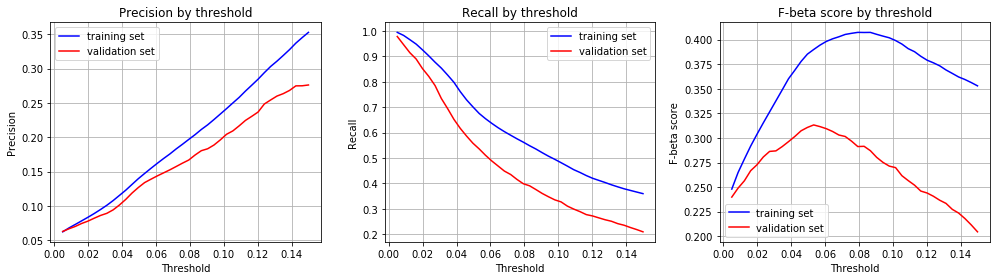

In [10]:
month_prediction = 3
index_month = [i for i, m in enumerate(months) if m == month_prediction][0]
y_train_all_ = [y[:, index_month] for y in y_train_all]
y_val_all_ = [y[:, index_month] for y in y_val_all]
y_pred_train_all_ = [y[:, index_month] for y in y_pred_train_all]
y_pred_val_all_ = [y[:, index_month] for y in y_pred_val_all]
beta = 2
rcParams['figure.figsize'] = 14, 4
eval_ = EvaluateResults(y_train_all_, y_val_all_, y_pred_train_all_, y_pred_val_all_, model_name, test_data)
eval_.find_threshold(beta=beta, threshold_min=0.005, threshold_max=0.15, resolution=40)

## Evaluate results

In [11]:
threshold = 0.07
beta = 2
print(model_name)
print('\n')
print('Predict crash in:               ' + str(month_prediction) + ' months')
print('Threshold for positives:        ' + str(threshold))
print('Number of features:             ' + str(dfs_x1[0].shape[1] + dfs_x2[0].shape[1]))
print('Number of rows in training set: ' + str(len(y_pred_train_all[0]) + len(y_pred_val_all[0])))
print('Number of epochs:               ' + str(epoch))
print('Sequence length:                ' + str(sequence))
print('Number of neurons/layer:        ' + str(neurons))
print('Batch size:                     ' + str(batch_size))
print('Optimizer:                      ' + str(optimizer))
print('Loss function:                  ' + str(loss))
print('\n')
eval_.training_results(threshold, training_set_names, beta=beta)

LSTM


Predict crash in:               3 months
Threshold for positives:        0.07
Number of features:             28
Number of rows in training set: 45780
Number of epochs:               10
Sequence length:                10
Number of neurons/layer:        50
Batch size:                     60
Optimizer:                      adam
Loss function:                  binary_crossentropy


Results for each train/val split:
                       N225   SSE   HSI  BSESN   SMI  BVSP
positive actual train  0.06  0.04  0.06   0.06  0.05  0.06
positive pred train    0.20  0.19  0.18   0.21  0.13  0.19
precision train        0.20  0.12  0.20   0.17  0.21  0.17
recall train           0.72  0.52  0.62   0.63  0.51  0.58
accuracy_train         0.82  0.81  0.83   0.80  0.87  0.82
score_fbeta train      0.48  0.31  0.43   0.41  0.40  0.40
positive actual val    0.05  0.11  0.04   0.04  0.05  0.04
positive pred val      0.24  0.15  0.17   0.20  0.10  0.15
precision val          0.07  0.32  0.08   0.09

## Train model on all training data for testing

In [12]:
test_data = 'S&P 500'
np_x1_train, np_x2_train, np_y_train, np_x1_test, np_x2_test, np_y_test = \
    data.get_train_test(dfs_x1, dfs_x2, dfs_y, dataset_names, test_data=test_data)
np_x_train = np.concatenate([np_x1_train, np_x2_train], axis=2)
np_x_test = np.concatenate([np_x1_test, np_x2_test], axis=2)
epochs = 10
model = rnn_lstm(neurons=neurons, inp_tsteps=inp_tsteps, inp_dim=inp_dim, dropout=dropout)
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
print('Train model for testing ' + str(model_name) + ' - test data: ' + str(test_data))
for e in range(epochs):
    model.fit(np_x_train, np_y_train, epochs=1, batch_size=batch_size, verbose=1, shuffle=True)
    if (e + 1) % 2 == 0:
        model.save_weights('stateless_s10_2d_bce_{0}_{1}.hdf5'.format(test_data, e + 1))

Train model for testing LSTM - test data: S&P 500
Epoch 1/1
45780/45780 [==============================] - 38s 830us/step - loss: 0.2000 - acc: 0.9424
Epoch 1/1
45780/45780 [==============================] - 34s 752us/step - loss: 0.1831 - acc: 0.9434
Epoch 1/1
45780/45780 [==============================] - 35s 757us/step - loss: 0.1815 - acc: 0.9438
Epoch 1/1
45780/45780 [==============================] - 34s 748us/step - loss: 0.1797 - acc: 0.9448
Epoch 1/1
45780/45780 [==============================] - 34s 752us/step - loss: 0.1774 - acc: 0.9456
Epoch 1/1
45780/45780 [==============================] - 34s 749us/step - loss: 0.1754 - acc: 0.9464
Epoch 1/1
45780/45780 [==============================] - 34s 750us/step - loss: 0.1740 - acc: 0.9467
Epoch 1/1
45780/45780 [==============================] - 35s 755us/step - loss: 0.1722 - acc: 0.9471
Epoch 1/1
45780/45780 [==============================] - 35s 754us/step - loss: 0.1702 - acc: 0.9477
Epoch 1/1
45780/45780 [==================

## Test model

In [14]:
test_data = 'S&P 500'
epoch = 10
threshold=0.07
month_prediction = 3   # <-- predict crash in 1, 3 or 6 months
index_month = [i for i, m in enumerate(months) if m == month_prediction][0]
_, _, _, np_x1_test, np_x2_test, np_y_test = \
    data.get_train_test(dfs_x1, dfs_x2, dfs_y, dataset_names, test_data=test_data)
np_x_test = np.concatenate([np_x1_test, np_x2_test], axis=2)
model.load_weights('stateless_s10_2d_bce_{0}_{1}.hdf5'.format(test_data, epoch))
y_pred_test = model.predict(np_x_test, batch_size=batch_size)[:, index_month]
y_test = np_y_test[:, index_month]
y_pred_test_bin = eval_.test_results(y_test, y_pred_test, threshold, beta=beta)

Test results (test set: S&P 500):
Positive test cases actual:         0.04
Positive test cases predicted:      0.13
Precision test (model/random):      0.16 / 0.04
Recall test (model/random):         0.51 / 0.13
Accuracy test (model/random):       0.87 / 0.84
Score test fbeta:                   0.35 / 0.09


## Plot test results

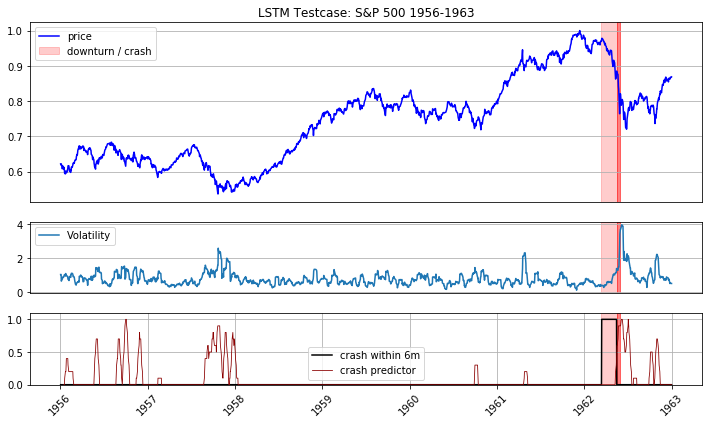

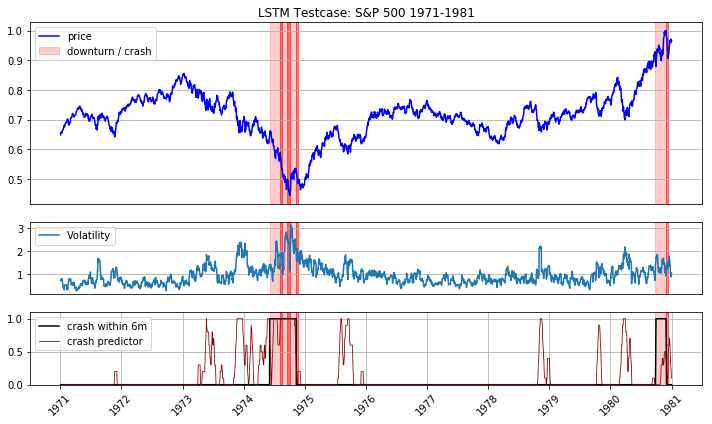

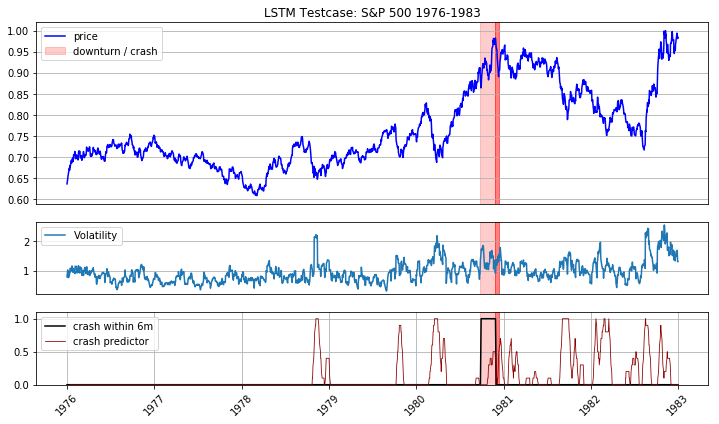

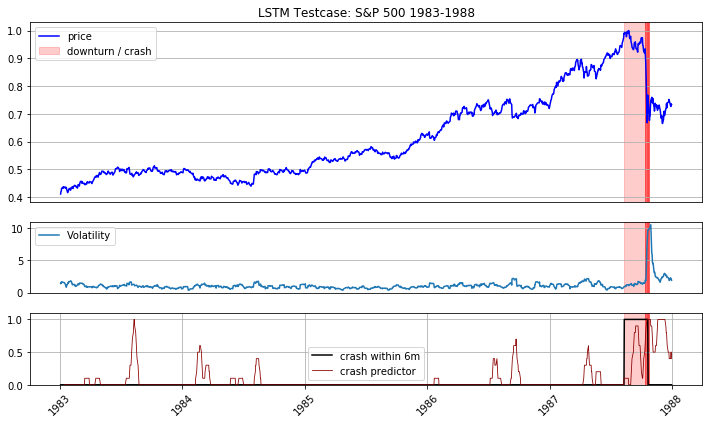

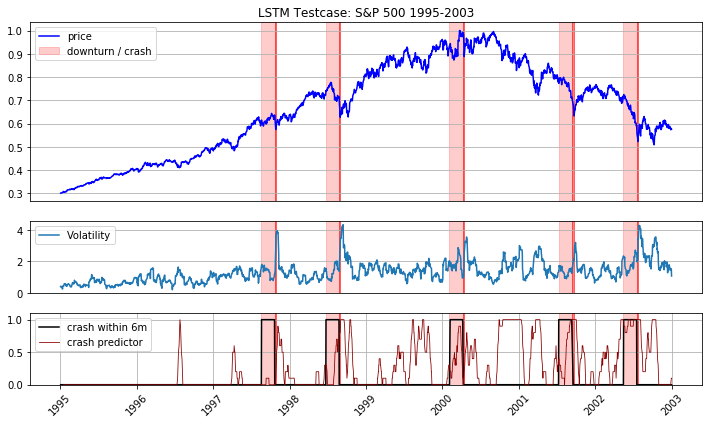

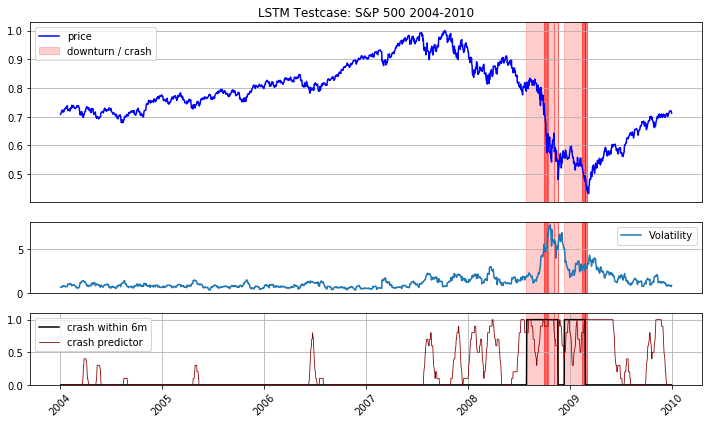

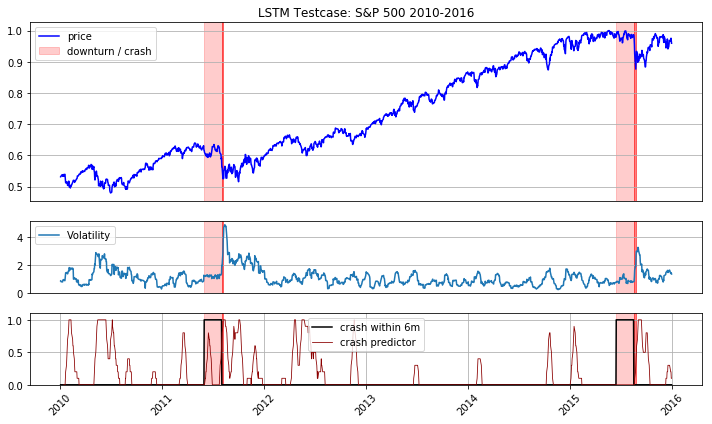

In [15]:
df = datasets_revised[index_test].reindex(dfs_x1[index_test].index)
df['y'] = y_test
df['y_pred'] = y_pred_test_bin
c = crashes[index_test]
t_start = ['1956-01-01', '1971-01-01', '1976-01-01', '1983-01-01', '1995-01-01', '2004-01-01', '2010-01-01']
t_end = ['1963-01-01', '1981-01-01', '1983-01-01', '1988-01-01', '2003-01-01', '2010-01-01', '2016-01-01']
rcParams['figure.figsize'] = 10, 6
eval_.plot_test_results(df, c, t_start, t_end)